In [1]:
# Check GPU

from tensorflow import test
from tensorflow.python.client import device_lib

if test.is_gpu_available:
    devices=device_lib.list_local_devices()
    gpu=[(x.physical_device_desc) for x in devices if x.device_type == 'GPU']
    print("GPU :", gpu)

GPU : ['device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5']


In [2]:
# Check framework versions being used 

import sys
import keras as K
import tensorflow as tf

print("Python", sys.version)
print("Tensorflow version", tf.__version__)
print("Keras version", K.__version__)

Python 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Tensorflow version 2.1.0
Keras version 2.3.1


Using TensorFlow backend.


In [3]:
# import NN architectures for speech recognition
from models import *

# import function for training acoustic model
from train_utils import train_model

In [4]:
# Import Additional Libraries

import re
import nltk

import numpy as np
import seaborn as sns
import _pickle as pickle
import matplotlib.pyplot as plt

from glob import glob
from nltk import trigrams
from nltk.corpus import brown
from utils import int_sequence_to_text
from collections import Counter, defaultdict
from data_generator import AudioGenerator, plot_raw_audio, plot_spectrogram_feature

from IPython.display import Markdown, display, Audio
from data_generator import vis_train_features, plot_mfcc_feature

In [5]:
sns.set_style(style = 'white')
nltk.download('brown')

[nltk_data] Downloading package brown to /home/tanmay/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [6]:
# Extract label and audio features for a single training example

vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


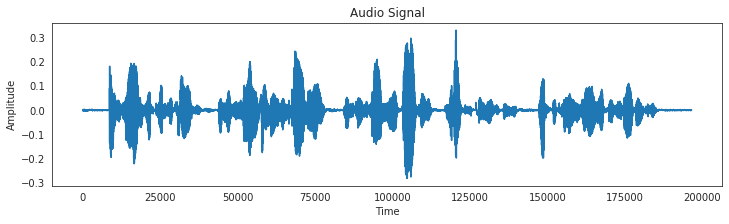

In [9]:
plot_raw_audio(vis_raw_audio)

In [10]:
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))

**Shape of Audio Signal** : (196576,)

In [11]:
display(Markdown('**Transcript** : ' + str(vis_text)))

**Transcript** : and now it had come to pass that his sole remaining ally mister samuel bozzle the ex policeman was becoming weary of his service

In [12]:
Audio(vis_audio_path)